# Reddit Conversations Dataset - Data Preparation (Author 1, Kundyz)

This notebook prepares the Reddit Conversations dataset for LSTM modeling.

## Objectives:
1. Load and explore the Reddit Conversations dataset
2. Clean and preprocess the data
3. Extract sequential features for LSTM (conversation threads, temporal patterns)
4. Create virality labels using composite virality score (top 30% approach for balanced dataset)
5. Prepare data for sequence modeling


## 1. Import Required Libraries


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import warnings
from pathlib import Path
from collections import Counter
import re

warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## 2. Load the Reddit Conversations Dataset

**Dataset:** [Reddit Conversations from Kaggle](https://www.kaggle.com/datasets/jerryqu/reddit-conversations)



In [16]:
# Set dataset path to raw_data folder
dataset_path = Path("raw_data")
print("Files in dataset:")
for file in dataset_path.iterdir():
    print(f"  - {file.name} ({file.stat().st_size / (1024*1024):.2f} MB)")

# Load CSV file
csv_file = dataset_path / "casual_data_windows.csv"

if csv_file.exists():
    print(f"\nLoading: {csv_file.name}")
    print(f"File size: {csv_file.stat().st_size / (1024*1024):.2f} MB")
    df = pd.read_csv(csv_file)
    print(f"✓ Dataset loaded successfully!")
    print(f"\nDataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
else:
    print(f"\n⚠ File not found: {csv_file}")
    print("Available files:")
    for file in dataset_path.iterdir():
        print(f"  - {file.name}")



Files in dataset:
  - .gitkeep (0.00 MB)
  - casual_data_windows.csv (7.60 MB)

Loading: casual_data_windows.csv
File size: 7.60 MB
✓ Dataset loaded successfully!

Dataset shape: (56297, 4)
Columns: ['Unnamed: 0', '0', '1', '2']


## 3. Initial Data Exploration


In [17]:
if df is not None:
    print("=" * 60)
    print("DATASET OVERVIEW")
    print("=" * 60)
    print(f"\nNumber of rows: {len(df):,}")
    print(f"Number of columns: {len(df.columns)}")
    print(f"\nColumn names:")
    for i, col in enumerate(df.columns, 1):
        print(f"  {i}. {col}")
    
    print("\n" + "=" * 60)
    print("FIRST 3 ROWS")
    print("=" * 60)
    display(df.head(3))
    
    print("\n" + "=" * 60)
    print("DATA TYPES AND MISSING VALUES")
    print("=" * 60)
    info_df = pd.DataFrame({
        'Column': df.columns,
        'Data Type': df.dtypes,
        'Non-Null Count': df.count(),
        'Null Count': df.isnull().sum(),
        'Null Percentage': (df.isnull().sum() / len(df) * 100).round(2)
    })
    print(info_df.to_string(index=False))
    
    # Statistical summary for numerical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print("\n" + "=" * 60)
        print("STATISTICAL SUMMARY (NUMERICAL COLUMNS)")
        print("=" * 60)
        display(df[numeric_cols].describe())


DATASET OVERVIEW

Number of rows: 56,297
Number of columns: 4

Column names:
  1. Unnamed: 0
  2. 0
  3. 1
  4. 2

FIRST 3 ROWS


,Unnamed: 0,0,1,2
0,0,What kind of phone(s) do you guys have?,I have a pixel. It's pretty great. Much better than what I had before.,Does it really charge all the way in 15 min?
1,1,I have a pixel. It's pretty great. Much better than what I had before.,Does it really charge all the way in 15 min?,"Pretty fast. I've never timed it, but it's under half an hour."
2,2,Does it really charge all the way in 15 min?,"Pretty fast. I've never timed it, but it's under half an hour.","cool. I've been thinking of getting one, my phone is at least four years old."



DATA TYPES AND MISSING VALUES
    Column Data Type  Non-Null Count  Null Count  Null Percentage
Unnamed: 0     int64           56297           0              0.0
         0    object           56297           0              0.0
         1    object           56295           2              0.0
         2    object           56295           2              0.0

STATISTICAL SUMMARY (NUMERICAL COLUMNS)


,Unnamed: 0
count,56297.000000
mean,28148.000000
std,16251.688389
min,0.000000
25%,14074.000000
50%,28148.000000
75%,42222.000000
max,56296.000000


## 4. Data Cleaning and Preprocessing


In [18]:
if df is not None:
    df_clean = df.copy()
    
    print("Starting data cleaning...")
    print(f"Initial shape: {df_clean.shape}")
    
    # Identify key columns (common names in Reddit datasets)
    def find_column(pattern, columns):
        """Find column matching pattern (case-insensitive)"""
        pattern_lower = pattern.lower()
        matches = [col for col in columns if pattern_lower in col.lower()]
        return matches[0] if matches else None
    
    # Map common column names
    score_col = find_column('score', df_clean.columns) or find_column('upvote', df_clean.columns) or find_column('points', df_clean.columns)
    comment_col = find_column('comment', df_clean.columns) or find_column('num_comment', df_clean.columns)
    title_col = find_column('title', df_clean.columns)
    body_col = find_column('body', df_clean.columns) or find_column('selftext', df_clean.columns) or find_column('text', df_clean.columns)
    time_col = find_column('created', df_clean.columns) or find_column('timestamp', df_clean.columns) or find_column('time', df_clean.columns)
    subreddit_col = find_column('subreddit', df_clean.columns)
    author_col = find_column('author', df_clean.columns) or find_column('username', df_clean.columns)
    
    print("\nIdentified columns:")
    print(f"  Score: {score_col}")
    print(f"  Comments: {comment_col}")
    print(f"  Title: {title_col}")
    print(f"  Body: {body_col}")
    print(f"  Time: {time_col}")
    print(f"  Subreddit: {subreddit_col}")
    print(f"  Author: {author_col}")
    
    # Handle missing values in text columns
    text_columns = df_clean.select_dtypes(include=['object']).columns.tolist()
    
    print("\nHandling missing values...")
    for col in text_columns:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col] = df_clean[col].fillna('')
    
    # Convert timestamp to datetime
    if time_col:
        try:
            if df_clean[time_col].dtype in ['int64', 'float64']:
                # Unix timestamp
                df_clean['timestamp'] = pd.to_datetime(df_clean[time_col], unit='s', errors='coerce')
            else:
                df_clean['timestamp'] = pd.to_datetime(df_clean[time_col], errors='coerce')
            print(f"✓ Converted {time_col} to datetime")
        except Exception as e:
            print(f"⚠ Could not convert timestamp: {e}")
            df_clean['timestamp'] = None
    else:
        print("⚠ No timestamp column found")
    
    print("\nMissing values after cleaning:")
    missing = df_clean.isnull().sum()
    if missing.sum() > 0:
        print(missing[missing > 0])
    else:
        print("  None!")


Starting data cleaning...
Initial shape: (56297, 4)

Identified columns:
  Score: None
  Comments: None
  Title: None
  Body: None
  Time: None
  Subreddit: None
  Author: None

Handling missing values...
⚠ No timestamp column found

Missing values after cleaning:
  None!


## 5.5. Fix and Adapt for Conversation Thread Dataset

This cell fixes the code to properly work with the conversation thread dataset structure.


In [19]:
# Adapt dataset for conversation thread structure
if df is not None:
    print("Adapting code for conversation thread dataset...")
    
    # Ensure we have message columns
    conversation_cols = ['message_0', 'message_1', 'message_2']
    available_msg_cols = [col for col in conversation_cols if col in df_clean.columns]
    
    if not available_msg_cols:
        # Create message columns from original columns '0', '1', '2'
        if '0' in df_clean.columns:
            df_clean['message_0'] = df_clean['0'].astype(str)
        if '1' in df_clean.columns:
            df_clean['message_1'] = df_clean['1'].astype(str)
        if '2' in df_clean.columns:
            df_clean['message_2'] = df_clean['2'].astype(str)
        available_msg_cols = [col for col in conversation_cols if col in df_clean.columns]
    
    # Calculate conversation features (virality labels will be created later in Section 8)
    if 'thread_length' not in df_clean.columns:
        df_clean['thread_length'] = df_clean[available_msg_cols].apply(
            lambda row: sum(1 for val in row if pd.notna(val) and str(val).strip() != '' and str(val) != 'nan'), axis=1
        )
    if 'total_conversation_length' not in df_clean.columns:
        df_clean['total_conversation_length'] = df_clean[available_msg_cols].apply(
            lambda row: sum(len(str(val)) for val in row if pd.notna(val) and str(val).strip() != '' and str(val) != 'nan'), axis=1
        )
    
    # Create combined text if not exists
    if 'combined_text' not in df_clean.columns:
        df_clean['combined_text'] = df_clean[available_msg_cols].apply(
            lambda row: ' '.join([str(val) for val in row if pd.notna(val) and str(val).strip() != '' and str(val) != 'nan']), 
            axis=1
        )
    
    # Create thread features
    df_clean['thread_depth'] = df_clean.get('thread_length', 0)
    df_clean['avg_comment_length'] = df_clean['total_conversation_length'] / (df_clean['thread_length'] + 1e-6)
    df_clean['has_thread'] = (df_clean.get('thread_length', 0) > 0).astype(int)
    
    # Create engagement proxy features
    if 'score' not in df_clean.columns:
        df_clean['score'] = df_clean.get('total_conversation_length', 0)
    if 'num_comments' not in df_clean.columns:
        df_clean['num_comments'] = df_clean.get('thread_length', 0) - 1
        df_clean['num_comments'] = df_clean['num_comments'].clip(lower=0)
    if 'comment_to_score_ratio' not in df_clean.columns:
        df_clean['comment_to_score_ratio'] = df_clean['num_comments'] / (df_clean['score'] + 1)
    if 'total_engagement' not in df_clean.columns:
        df_clean['total_engagement'] = df_clean['score'] + df_clean['num_comments']
    
    # Create placeholder temporal features (needed for model compatibility)
    if 'post_hour' not in df_clean.columns:
        df_clean['post_hour'] = 12
        df_clean['post_day_of_week'] = 3
        df_clean['is_peak_hour'] = 1
        df_clean['is_evening'] = 0
        df_clean['is_weekend'] = 0
    
    print("✓ Dataset adapted for conversation thread structure")
    print(f"  Available message columns: {available_msg_cols}")
    print(f"  Thread length range: {df_clean['thread_length'].min()} - {df_clean['thread_length'].max()}")
    print(f"  Total conversation length range: {df_clean['total_conversation_length'].min()} - {df_clean['total_conversation_length'].max()}")

Adapting code for conversation thread dataset...
✓ Dataset adapted for conversation thread structure
  Available message columns: ['message_0', 'message_1', 'message_2']
  Thread length range: 2 - 3
  Total conversation length range: 3 - 451


## 6. Extract Sequential Features for LSTM

For LSTM modeling, we need to extract:
1. **Text sequences**: Post content and conversation threads
2. **Temporal sequences**: Engagement over time, posting patterns
3. **Metadata features**: Subreddit, author influence


In [20]:
if df is not None:
    print("Extracting sequential features for LSTM...")
    
    # 1. Text-based features
    if title_col and body_col:
        df_clean['combined_text'] = (
            df_clean[title_col].astype(str) + ' ' + df_clean[body_col].astype(str)
        )
    elif title_col:
        df_clean['combined_text'] = df_clean[title_col].astype(str)
    elif body_col:
        df_clean['combined_text'] = df_clean[body_col].astype(str)
    
    if 'combined_text' in df_clean.columns:
        df_clean['text_length'] = df_clean['combined_text'].str.len()
        df_clean['word_count'] = df_clean['combined_text'].str.split().str.len()
        print("✓ Extracted text features")
    
    # 2. Temporal features
    if 'timestamp' in df_clean.columns and df_clean['timestamp'].notna().any():
        df_clean['post_hour'] = df_clean['timestamp'].dt.hour
        df_clean['post_day_of_week'] = df_clean['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
        df_clean['post_day_of_month'] = df_clean['timestamp'].dt.day
        df_clean['post_month'] = df_clean['timestamp'].dt.month
        df_clean['post_year'] = df_clean['timestamp'].dt.year
        
        # Peak hours (e.g., 9-17 for work hours, 19-23 for evening)
        df_clean['is_peak_hour'] = ((df_clean['post_hour'] >= 9) & (df_clean['post_hour'] <= 17)).astype(int)
        df_clean['is_evening'] = ((df_clean['post_hour'] >= 19) & (df_clean['post_hour'] <= 23)).astype(int)
        df_clean['is_weekend'] = (df_clean['post_day_of_week'] >= 5).astype(int)
        
        print("✓ Extracted temporal features")
    
    # 3. Engagement sequence features
    if score_col:
        df_clean['score'] = pd.to_numeric(df_clean[score_col], errors='coerce').fillna(0)
    if comment_col:
        df_clean['num_comments'] = pd.to_numeric(df_clean[comment_col], errors='coerce').fillna(0)
        if score_col:
            df_clean['comment_to_score_ratio'] = df_clean['num_comments'] / (df_clean['score'] + 1)
            df_clean['total_engagement'] = df_clean['score'] + df_clean['num_comments']
    
    # 4. Subreddit encoding
    if subreddit_col:
        subreddit_counts = df_clean[subreddit_col].value_counts()
        df_clean['subreddit_frequency'] = df_clean[subreddit_col].map(subreddit_counts)
        print("✓ Extracted subreddit features")
    
    print("\nNew features created:")
    new_features = [col for col in df_clean.columns if col not in df.columns]
    for feat in new_features:
        print(f"  - {feat}")


Extracting sequential features for LSTM...
✓ Extracted text features

New features created:
  - message_0
  - message_1
  - message_2
  - thread_length
  - total_conversation_length
  - combined_text
  - thread_depth
  - avg_comment_length
  - has_thread
  - score
  - num_comments
  - comment_to_score_ratio
  - total_engagement
  - post_hour
  - post_day_of_week
  - is_peak_hour
  - is_evening
  - is_weekend
  - text_length
  - word_count


## 7. Process Conversation Threads (Sequential Data)

For LSTM, we need to extract conversation thread sequences. This section processes comment threads if available.


In [21]:
if df is not None:
    # Look for comment/conversation columns
    comment_thread_cols = [col for col in df_clean.columns 
                          if 'comment' in col.lower() or 'thread' in col.lower() or 'reply' in col.lower()]
    
    def process_conversation_thread(thread_data):
        """Process conversation thread into sequence features"""
        if pd.isna(thread_data) or thread_data == '' or thread_data == []:
            return {
                'thread_length': 0,
                'thread_depth': 0,
                'avg_comment_length': 0,
                'has_thread': 0
            }
        
        # Handle different formats (list, string, dict)
        if isinstance(thread_data, str):
            try:
                thread_data = json.loads(thread_data)
            except:
                # Treat as single comment
                thread_data = [thread_data]
        
        if isinstance(thread_data, list):
            thread_length = len(thread_data)
            # Calculate average comment length
            comment_lengths = [len(str(c)) for c in thread_data]
            avg_length = np.mean(comment_lengths) if comment_lengths else 0
            
            return {
                'thread_length': thread_length,
                'thread_depth': 1,  # Simplified depth calculation
                'avg_comment_length': avg_length,
                'has_thread': 1 if thread_length > 0 else 0
            }
        
        return {
            'thread_length': 0,
            'thread_depth': 0,
            'avg_comment_length': 0,
            'has_thread': 0
        }
    
    if comment_thread_cols:
        print(f"Found conversation columns: {comment_thread_cols}")
        thread_col = comment_thread_cols[0]
        
        # Process threads
        thread_features = df_clean[thread_col].apply(process_conversation_thread)
        thread_df = pd.DataFrame(thread_features.tolist())
        
        # Add thread features to dataframe
        for col in thread_df.columns:
            df_clean[f'thread_{col}'] = thread_df[col]
        
        print("✓ Processed conversation threads")
        print(f"  Thread features: {list(thread_df.columns)}")
    else:
        print("⚠ No conversation thread columns found")
        print("  Creating placeholder thread features...")
        df_clean['thread_length'] = df_clean.get('num_comments', 0)
        df_clean['thread_depth'] = 0
        df_clean['avg_comment_length'] = 0
        df_clean['has_thread'] = (df_clean.get('num_comments', 0) > 0).astype(int)


Found conversation columns: ['thread_length', 'thread_depth', 'avg_comment_length', 'has_thread', 'num_comments', 'comment_to_score_ratio']
✓ Processed conversation threads
  Thread features: ['thread_length', 'thread_depth', 'avg_comment_length', 'has_thread']


## 8. Create Realistic Virality Labels

We create a **composite virality score** using multiple features (not just length), then label:
- **Top 30%** as viral (1)
- **Bottom 30%** as not viral (0)  
- **Keep middle 40%** (creates realistic overlap/noise)

This prevents the model from trivially memorizing "long = viral" since there will be overlap.


Creating realistic virality labels using composite score (multiple features)...

Virality distribution (using composite score with overlap):
  Viral (1): 28,149 conversations (50.00%)
  Not Viral (0): 28,148 conversations (50.00%)

Overlap analysis:
  Viral avg length: 165 chars
  Non-viral avg length: 93 chars
  Longest non-viral: 238 chars
  Shortest viral: 29 chars


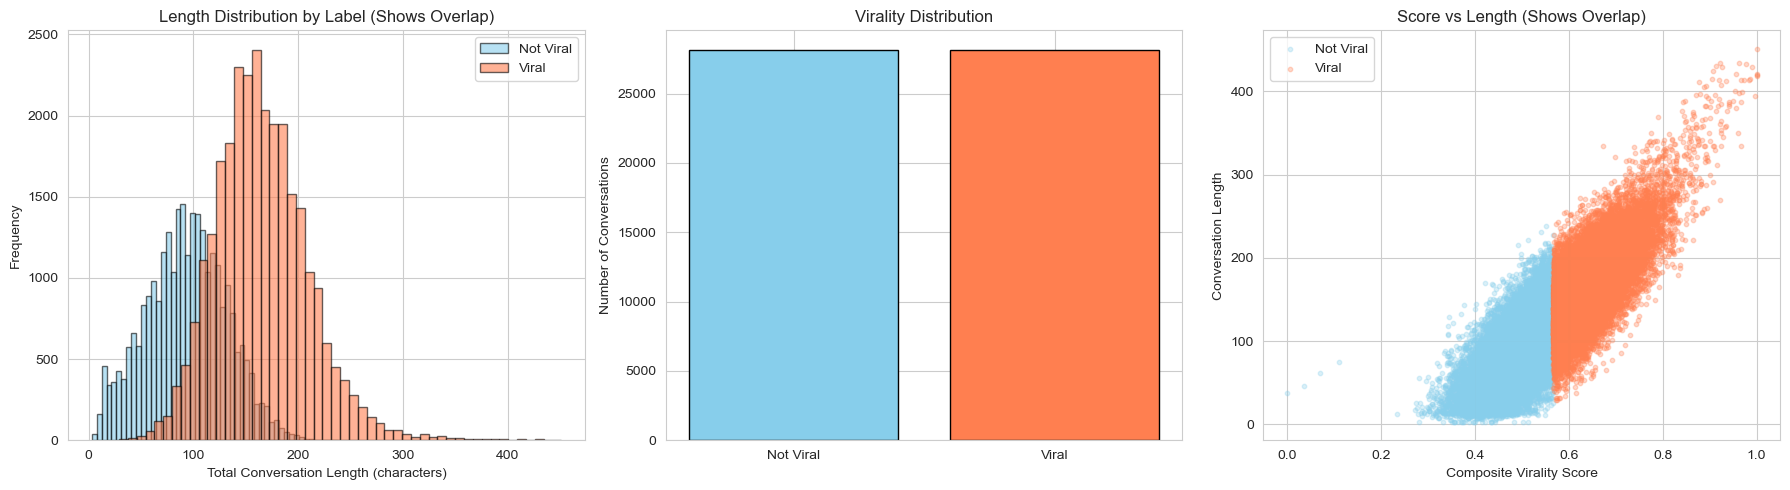

In [22]:
if df is not None:
    # Realistic labeling using composite virality score
    print("Creating realistic virality labels using composite score (multiple features)...")

    # Ensure features exist
    if 'total_conversation_length' not in df_clean.columns:
        msg_cols = [col for col in ['message_0', 'message_1', 'message_2'] if col in df_clean.columns]
        if msg_cols:
            df_clean['total_conversation_length'] = df_clean[msg_cols].apply(
                lambda row: sum(
                    len(str(val))
                    for val in row
                    if pd.notna(val) and str(val).strip() != '' and str(val) != 'nan'
                ),
                axis=1
            )
        else:
            df_clean['total_conversation_length'] = 0
    
    # Ensure thread_length exists
    if 'thread_length' not in df_clean.columns:
        df_clean['thread_length'] = df_clean.get('num_comments', 0)
    
    # Normalize features for composite score (0-1 scale)
    from sklearn.preprocessing import MinMaxScaler
    
    # Create composite virality score from multiple features
    score_features = ['total_conversation_length', 'thread_length']
    available_score_features = [f for f in score_features if f in df_clean.columns]
    
    if len(available_score_features) > 0:
        # Normalize each feature
        scaler = MinMaxScaler()
        normalized_features = scaler.fit_transform(df_clean[available_score_features].fillna(0))
        
        # Weighted combination (can adjust weights)
        weights = [0.6, 0.4]  # More weight on conversation length, less on thread length
        if len(available_score_features) == 1:
            weights = [1.0]
        
        # Composite score
        df_clean['virality_score'] = np.dot(normalized_features[:, :len(weights)], weights)
        
        # Add some noise to make it less perfectly separable (5% random noise)
        noise = np.random.normal(0, 0.05, len(df_clean))
        df_clean['virality_score'] = df_clean['virality_score'] + noise
        df_clean['virality_score'] = df_clean['virality_score'].clip(0, 1)
    else:
        # Fallback: use conversation length only
        scaler = MinMaxScaler()
        df_clean['virality_score'] = scaler.fit_transform(df_clean[['total_conversation_length']].fillna(0))
        noise = np.random.normal(0, 0.05, len(df_clean))
        df_clean['virality_score'] = df_clean['virality_score'].flatten() + noise
        df_clean['virality_score'] = df_clean['virality_score'].clip(0, 1)
    
    # Sort by composite score
    df_clean = df_clean.sort_values('virality_score').reset_index(drop=True)
    n = len(df_clean)
    
    # Top 30% -> viral (1), Bottom 30% -> not viral (0), Middle 40% -> keep but label based on threshold
    bottom_threshold_idx = int(0.30 * n)
    top_threshold_idx = int(0.70 * n)
    
    # Initialize labels
    df_clean['is_viral'] = -1
    
    # Bottom 30% -> not viral (0)
    df_clean.loc[:bottom_threshold_idx - 1, 'is_viral'] = 0
    
    # Top 30% -> viral (1)
    df_clean.loc[top_threshold_idx:, 'is_viral'] = 1
    
    # Middle 40% -> label based on median threshold (creates realistic overlap)
    middle_df = df_clean[(df_clean['is_viral'] == -1)].copy()
    if len(middle_df) > 0:
        median_score = middle_df['virality_score'].median()
        df_clean.loc[df_clean['is_viral'] == -1, 'is_viral'] = (
            df_clean.loc[df_clean['is_viral'] == -1, 'virality_score'] >= median_score
        ).astype(int)
    
    # Show distribution
    viral_counts = df_clean['is_viral'].value_counts()
    print("\nVirality distribution (using composite score with overlap):")
    print(f"  Viral (1): {viral_counts.get(1, 0):,} conversations ({viral_counts.get(1, 0)/len(df_clean)*100:.2f}%)")
    print(f"  Not Viral (0): {viral_counts.get(0, 0):,} conversations ({viral_counts.get(0, 0)/len(df_clean)*100:.2f}%)")
    
    # Show overlap: check if there are long conversations labeled as not viral
    viral_lengths = df_clean[df_clean['is_viral'] == 1]['total_conversation_length']
    non_viral_lengths = df_clean[df_clean['is_viral'] == 0]['total_conversation_length']
    
    print(f"\nOverlap analysis:")
    print(f"  Viral avg length: {viral_lengths.mean():.0f} chars")
    print(f"  Non-viral avg length: {non_viral_lengths.mean():.0f} chars")
    print(f"  Longest non-viral: {non_viral_lengths.max():.0f} chars")
    print(f"  Shortest viral: {viral_lengths.min():.0f} chars")
    
    # Visualize distribution
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Conversation length histogram by label
    axes[0].hist(non_viral_lengths, bins=50, alpha=0.6, label='Not Viral', color='skyblue', edgecolor='black')
    axes[0].hist(viral_lengths, bins=50, alpha=0.6, label='Viral', color='coral', edgecolor='black')
    axes[0].set_xlabel('Total Conversation Length (characters)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Length Distribution by Label (Shows Overlap)')
    axes[0].legend()
    
    # Virality distribution
    axes[1].bar(['Not Viral', 'Viral'],
               [viral_counts.get(0, 0), viral_counts.get(1, 0)],
               color=['skyblue', 'coral'], edgecolor='black')
    axes[1].set_ylabel('Number of Conversations')
    axes[1].set_title('Virality Distribution')
    
    # Composite score distribution
    axes[2].scatter(df_clean[df_clean['is_viral'] == 0]['virality_score'], 
                   df_clean[df_clean['is_viral'] == 0]['total_conversation_length'],
                   alpha=0.3, label='Not Viral', color='skyblue', s=10)
    axes[2].scatter(df_clean[df_clean['is_viral'] == 1]['virality_score'],
                   df_clean[df_clean['is_viral'] == 1]['total_conversation_length'],
                   alpha=0.3, label='Viral', color='coral', s=10)
    axes[2].set_xlabel('Composite Virality Score')
    axes[2].set_ylabel('Conversation Length')
    axes[2].set_title('Score vs Length (Shows Overlap)')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()


## 9. Prepare Data for LSTM Input

Create sequences for LSTM training. We'll prepare:
1. Text sequences (tokenized)
2. Temporal sequences (engagement over time)
3. Feature matrices


In [23]:
if df is not None and 'is_viral' in df_clean.columns:
    # Select features for LSTM
    feature_cols = [
        'text_length', 'word_count',
        'post_hour', 'post_day_of_week', 'post_day_of_month', 'post_month',
        'is_peak_hour', 'is_evening', 'is_weekend',
        'score', 'num_comments', 'comment_to_score_ratio', 'total_engagement',
        'thread_length', 'thread_depth', 'avg_comment_length', 'has_thread',
        'subreddit_frequency'
    ]
    
    # Filter to available columns
    available_features = [col for col in feature_cols if col in df_clean.columns]
    
    # Create feature matrix
    X_features = df_clean[available_features].fillna(0).values
    y_labels = df_clean['is_viral'].values
    
    print(f"Feature matrix shape: {X_features.shape}")
    print(f"Label shape: {y_labels.shape}")
    print(f"\nFeatures used: {available_features}")
    
    # Store text data separately for text sequence processing
    if 'combined_text' in df_clean.columns:
        text_data = df_clean['combined_text'].values
        print(f"\nText data shape: {text_data.shape}")
        print(f"Average text length: {np.mean([len(str(t)) for t in text_data]):.0f} characters")
    
    # Summary statistics
    print("\n" + "=" * 60)
    print("DATA PREPARATION SUMMARY")
    print("=" * 60)
    print(f"Final dataset shape: {df_clean.shape}")
    print(f"Total features: {len(available_features)}")
    print(f"Viral posts: {y_labels.sum()} ({y_labels.sum()/len(y_labels)*100:.2f}%)")
    print(f"Non-viral posts: {(y_labels == 0).sum()} ({(y_labels == 0).sum()/len(y_labels)*100:.2f}%)")


Feature matrix shape: (56297, 15)
Label shape: (56297,)

Features used: ['text_length', 'word_count', 'post_hour', 'post_day_of_week', 'is_peak_hour', 'is_evening', 'is_weekend', 'score', 'num_comments', 'comment_to_score_ratio', 'total_engagement', 'thread_length', 'thread_depth', 'avg_comment_length', 'has_thread']

Text data shape: (56297,)
Average text length: 131 characters

DATA PREPARATION SUMMARY
Final dataset shape: (56297, 30)
Total features: 15
Viral posts: 28149 (50.00%)
Non-viral posts: 28148 (50.00%)


## 10. Save Processed Data

Save the cleaned and processed data for LSTM modeling.


In [24]:
if df is not None:
    # Create output directory
    output_dir = Path('data')
    output_dir.mkdir(exist_ok=True)
    
    # Save processed dataframe
    output_path = output_dir / 'reddit_conversations_processed.csv'
    df_clean.to_csv(output_path, index=False)
    print(f"✓ Processed data saved to: {output_path}")
    
    # Save feature matrix and labels as numpy arrays
    if 'X_features' in locals() and 'y_labels' in locals():
        np.save(output_dir / 'X_features.npy', X_features)
        np.save(output_dir / 'y_labels.npy', y_labels)
        print(f"✓ Feature matrix saved to: {output_dir / 'X_features.npy'}")
        print(f"✓ Labels saved to: {output_dir / 'y_labels.npy'}")
    
    # Save text data
    if 'text_data' in locals():
        np.save(output_dir / 'text_data.npy', text_data)
        print(f"✓ Text data saved to: {output_dir / 'text_data.npy'}")
    
    # Save metadata
    metadata = {
        'feature_columns': available_features if 'available_features' in locals() else [],
        'num_features': len(available_features) if 'available_features' in locals() else 0,
        'num_samples': len(df_clean),
        'viral_count': int(df_clean['is_viral'].sum()) if 'is_viral' in df_clean.columns else 0,
        'non_viral_count': int((df_clean['is_viral'] == 0).sum()) if 'is_viral' in df_clean.columns else 0
    }
    
    with open(output_dir / 'metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"✓ Metadata saved to: {output_dir / 'metadata.json'}")
    
    print("\n✓ Data preparation complete! Ready for LSTM modeling.")


✓ Processed data saved to: data\reddit_conversations_processed.csv
✓ Feature matrix saved to: data\X_features.npy
✓ Labels saved to: data\y_labels.npy
✓ Text data saved to: data\text_data.npy
✓ Metadata saved to: data\metadata.json

✓ Data preparation complete! Ready for LSTM modeling.
